In [1]:
import os
import random
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import Block, rnn, nn

# Fixing the random seed
def set_seed(seed, ctx):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    mx.random.seed(seed, ctx=ctx)
    
ctx = mx.gpu()
set_seed(42, ctx)
batch_size=100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

# Load MNIST

In [2]:
mnist = mx.test_utils.get_mnist()
mnist.keys()

dict_keys(['train_data', 'train_label', 'test_data', 'test_label'])

In [3]:
mnist['train_data'].shape

(60000, 1, 28, 28)

In [4]:
train_set = gluon.data.DataLoader(gluon.data.ArrayDataset([nd.array(data) for data in mnist['train_data']]), 
                                 batch_size=batch_size, last_batch="discard", shuffle=True)
test_set = gluon.data.DataLoader(gluon.data.ArrayDataset([(nd.array(data),nd.array([label])) for data, label in zip(mnist['test_data'],mnist['test_label'])]), 
                                 batch_size=batch_size, last_batch="discard", shuffle=False)

# Modeling

In [5]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = nd.normal(shape=(nd.shape_array(z_mean).asnumpy()[0], latent_dim),
                        loc=0.,
                        scale=epsilon_std,
                        ctx=ctx)
    return z_mean + nd.exp(z_log_var / 2) * epsilon

class Encoder(gluon.HybridBlock):
    def __init__(self, intermediate_dim, latent_dim, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        with self.name_scope():
            self.h = nn.HybridSequential()
            self.h.add(nn.Dense(intermediate_dim, activation='relu'))
            self.h.add(nn.Dense(intermediate_dim//2, activation='relu')) # 중간층
            self.z_mean = nn.Dense(latent_dim, prefix="mean") # 잠재공간의 평균
            self.z_log_var = nn.Dense(latent_dim, prefix="log-variance") # 잠재공간의 로그분산

    def forward(self, x):
        h = self.h(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        # 잠재공간 z, 평균과 분산에 의해 정의되는 정규분포
        epsilon = nd.normal(shape=(batch_size, latent_dim),
                            loc=0.,
                            scale=epsilon_std,
                            ctx=ctx)
        z = z_mean + nd.exp(z_log_var / 2) * epsilon
        
        return [z_mean, z_log_var, z]
    
class Decoder(gluon.HybridBlock):
    def __init__(self, intermediate_dim, original_dim, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        with self.name_scope():
            self.h = nn.HybridSequential()
            self.h.add(nn.Dense(intermediate_dim//2, activation='relu'))
            self.h.add(nn.Dense(intermediate_dim, activation='relu')) # 잠재공간을 중간층 차원으로 변환
            self.x_mean = nn.Dense(original_dim, activation='sigmoid', prefix="flat_decoded") # 원본 차원으로 변환
            
    def forward(self, z):
        x_decoded = self.x_mean(self.h(z))
        
        return x_decoded

class AutoEncoder(Block):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        with self.name_scope():
            self.encoder = encoder
            self.decoder = decoder
            
    def forward(self, x):
        # grab the output. Recall, that we need to grab the 3rd element our sampling z
        enc_out = encoder(x)
        output_combined = decoder(enc_out[2])
        
        return output_combined, enc_out[:2]

In [6]:
encoder = Encoder(intermediate_dim, latent_dim)
decoder = Decoder(intermediate_dim, original_dim)
net = AutoEncoder(encoder, decoder)
net.initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
net

AutoEncoder(
  (encoder): Encoder(
    (h): HybridSequential(
      (0): Dense(None -> 256, Activation(relu))
      (1): Dense(None -> 128, Activation(relu))
    )
    (z_mean): Dense(None -> 2, linear)
    (z_log_var): Dense(None -> 2, linear)
  )
  (decoder): Decoder(
    (h): HybridSequential(
      (0): Dense(None -> 128, Activation(relu))
      (1): Dense(None -> 256, Activation(relu))
    )
    (x_mean): Dense(None -> 784, Activation(sigmoid))
  )
)

# Training Functions

In [7]:
class VAELoss(gluon.loss.Loss):
    def __init__(self, weight=None, batch_axis=0, **kwargs):
        super(VAELoss, self).__init__(weight, batch_axis, **kwargs)
        self.soft_zero = 1e-10

    def hybrid_forward(self, F, x_decoded_mean, x, z_mean, z_log_var):
        x = x.reshape(batch_size,-1)
        # reconst loss
        logloss = F.sum(x*F.log(x_decoded_mean+self.soft_zero)+ (1-x)*F.log(1-x_decoded_mean+self.soft_zero), axis=1) 
        # latent loss
        kl_loss = - 0.5 * F.sum(1 + z_log_var - F.square(z_mean) - F.exp(z_log_var), axis=-1) 
        vae_loss = -logloss+kl_loss
        return vae_loss
    
loss_fn = VAELoss()
optimizer = "adam"
lr = 0.001
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params={"learning_rate": lr})

In [8]:
def calc_totalloss(loss, batch_size, data_size):
    return (loss / (batch_size * data_size)).asscalar()

def training(model, batch_size, train_set, loss_viz, ctx):
    global trainer, loss_fn
    train_loss = mx.nd.zeros(1, ctx=ctx)
    
    for x in train_set:
        x = x.as_in_context(ctx)
        
        with autograd.record():
            x_decoded_mean, [z_mean, z_log_var] = model(x)
            losses = loss_fn(x_decoded_mean, x, z_mean, z_log_var)

        losses.backward()
        trainer.update(batch_size)
        train_loss += (sum(losses) / batch_size)

    total = calc_totalloss(train_loss, batch_size, len(train_set))
    loss_viz.append(total)

    print("Train loss: {:.6f}".format(total))
    
def validation(model, batch_size, val_set, loss_viz, ctx):
    global loss_fn
    val_loss = mx.nd.zeros(1, ctx=ctx)
    
    for x, _ in val_set:
        x = x.as_in_context(ctx)
        x_decoded_mean, [z_mean, z_log_var] = model(x)
        losses = loss_fn(x_decoded_mean, x, z_mean, z_log_var)
        val_loss += (sum(losses) / batch_size)

    total = calc_totalloss(val_loss, batch_size, len(val_set))
    loss_viz.append(total)
    
    print("Test loss: {:.6f}".format(total))

def main():
    global train_loss, val_loss
    tic = time.time()
    best_loss = float("Inf")

    for epoch in range(epochs):
        etic = time.time()
        print('Epoch {}'.format(epoch + 1))

        training(net, batch_size, train_set, train_loss, ctx)
        validation(net, batch_size, test_set, val_loss, ctx)

        print('Time: {:.3f}'.format(time.time() - etic))

        if np.isnan(val_loss[-1]):
            break

        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            net.save_parameters(f'./best_loss.param')
            print('save best loss model')

    print('Train speed: {:.3f}, Best Test loss: {}'.format(time.time() - tic, best_loss))

# Training

In [9]:
if __name__=="__main__":
    train_loss, val_loss = [], []
    main()

Epoch 1
Train loss: 1.882870
Test loss: 1.679535
Time: 4.858
save best loss model
Epoch 2
Train loss: 1.648724
Test loss: 1.623572
Time: 4.291
save best loss model
Epoch 3
Train loss: 1.596463
Test loss: 1.578734
Time: 4.126
save best loss model
Epoch 4
Train loss: 1.558134
Test loss: 1.548421
Time: 4.114
save best loss model
Epoch 5
Train loss: 1.532122
Test loss: 1.528198
Time: 4.193
save best loss model
Epoch 6
Train loss: 1.512807
Test loss: 1.511273
Time: 4.121
save best loss model
Epoch 7
Train loss: 1.498103
Test loss: 1.498712
Time: 4.109
save best loss model
Epoch 8
Train loss: 1.485201
Test loss: 1.485081
Time: 4.114
save best loss model
Epoch 9
Train loss: 1.475073
Test loss: 1.479769
Time: 4.107
save best loss model
Epoch 10
Train loss: 1.466170
Test loss: 1.469686
Time: 4.149
save best loss model
Epoch 11
Train loss: 1.459649
Test loss: 1.465110
Time: 4.161
save best loss model
Epoch 12
Train loss: 1.453117
Test loss: 1.458235
Time: 4.114
save best loss model
Epoch 13
Trai

# Display a 2D plot of the digit classes in the latent space

학습된 잠재공간에 원본 데이터 x를 입력하여 새로운 샘플 데이터(x_test_encoded)를 얻고 잠재공간에서 표현되는 x의 클래스를 시각화

In [10]:
net.load_parameters(f'./best_loss.param', ctx=ctx)

x_test_encoded, y_test = list(), list()
for x, y in test_set:
    x = x.as_in_context(ctx)
    x_test_encoded.append(net.encoder(x)[0])
    y_test.append(y)
        
x_test_encoded = np.concatenate([batch.asnumpy() for batch in x_test_encoded])
y_test = np.concatenate([batch.asnumpy() for batch in y_test])

x_test_encoded.shape, y_test.shape

((10000, 2), (10000, 1))

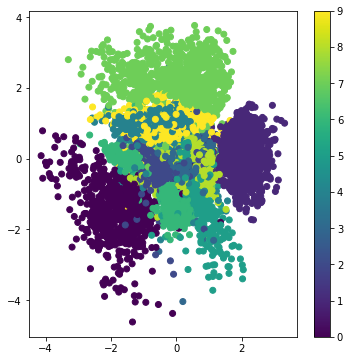

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

# Display a 2D manifold of the digits

인코더는 입력 x가 어떤 분포로부터 나온 샘플인지, 샘플들에 대한 가우시안 분포를 학습한다.  
학습이 끝난 후 가우시안 분포로부터 랜덤하게 샘플을 추출하고, 이를 디코더에 입력하여 새로운 샘플 x'을 생성한다.  
잠재공간의 값을 일정 간격으로 나누어 디코더에 전달(z_sample)하여 그 결과 값을 시각화.  
z에 따라 결과가 어떻게 달라지는지 보여준다.

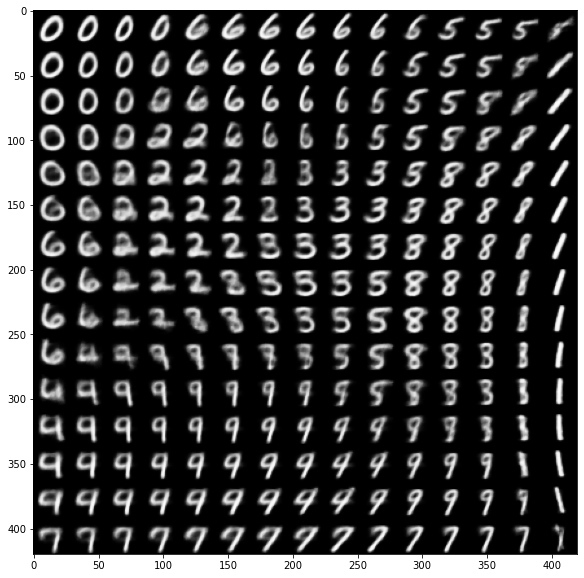

In [12]:
from scipy.stats import norm

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

'''
the inverse CDF (ppf) of the Gaussian
어떤 특정한 함수를 따르는 랜덤 샘플을 추출하고자 할 때 사용하는 방법.
가우시안 분포를 만족시키는 랜덤 샘플 추출은 다음과 같다.
'''
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) # 0.05부터 0.95까지 n개로 일정하게 값을 나누고, inverse CDF 계산.
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = nd.array(np.array([[xi, yi]]), ctx=ctx) # 랜덤 가우시안 샘플(평균,로그분산)
        x_decoded = net.decoder(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.asnumpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()